In [1]:
from pygadgetreader import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colors import LogNorm
from collections import defaultdict
import pandas as pd
from collections import Counter


In [4]:
def group_halos(particles):
    '''Arg: particles from readrockstargalaxies(halo binary file,'particles');
    will create & return a dictionary of halo ids and arrays of the
    corresponding particle ids belonging to each halo'''
    pids = particles[:, 0]
    hids = particles[:, 1]
    # arrays already sorted by halo, so find unique halo ids
    # & the num of particles in each one, then split particle ids by this num of counts,
    # but drop last one for end of arr
    unique_halos, cnts = np.unique(hids, return_counts=True)
    split_pids = np.split(pids, np.cumsum(cnts)[:-1])
    return dict(zip(unique_halos, split_pids))

In [ ]:
# data
# file names, replace with your own files
ss1 = '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.60'
ss2 = '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.70'
ss3 = '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.80'
ss4 = '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.87'
ss5 = '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=0.90'
ss6 = '/mnt/c/Users/doman/OneDrive/Desktop/dcdmtut3/snapshot_a=1.00'

ss1_halos = '/mnt/c/Users/doman/OneDrive/Desktop/rs1/halos_0'
ss2_halos = '/mnt/c/Users/doman/OneDrive/Desktop/rs2/halos_0'
ss3_halos = '/mnt/c/Users/doman/OneDrive/Desktop/rs3/halos_0'
ss4_halos = '/mnt/c/Users/doman/OneDrive/Desktop/rs4/halos_0'
ss5_halos = '/mnt/c/Users/doman/OneDrive/Desktop/rs5/halos_0'
ss6_halos = '/mnt/c/Users/doman/OneDrive/Desktop/rs6/halos_0'

# particle 2d arrays w hid membership info
particles1 = readrockstargalaxies(ss1_halos,'particles')
particles2 = readrockstargalaxies(ss2_halos,'particles')
particles3 = readrockstargalaxies(ss3_halos,'particles')
particles4 = readrockstargalaxies(ss4_halos,'particles')
particles5 = readrockstargalaxies(ss5_halos,'particles')
particles6 = readrockstargalaxies(ss6_halos,'particles')

# all halo info (in form of structured np array)
halos1 = readrockstargalaxies(ss1_halos,'halos') 
halos2 = readrockstargalaxies(ss2_halos,'halos') 
halos3 = readrockstargalaxies(ss3_halos,'halos')
halos4 = readrockstargalaxies(ss4_halos,'halos')
halos5 = readrockstargalaxies(ss5_halos,'halos') 
halos6 = readrockstargalaxies(ss6_halos,'halos') 


In [17]:
# make halo dictionaries for all using group_halos
halodic1 = group_halos(particles1)
halodic2 = group_halos(particles2)
halodic3 = group_halos(particles3)
halodic4 = group_halos(particles4)
halodic5 = group_halos(particles5)
halodic6 = group_halos(particles6)

halo_dicts = [halodic1, halodic2, halodic3, halodic4, halodic5, halodic6]

# particle masses in Msun/h
m = 7.88972e9

In [18]:
def plot_density(snapshot, bins, m, proj_axis="z", halo_file=None, plot_halos=False,
                 surf_density=True, boxsize=None, zoom = None, r_lim = None, label_halos=False, hids=None):
    ''' 
    2d projection of the density field.
    Args:
    positions: array of 3d positions in Cartesian coords from pygadgetreaders readsnap
    bins: number of bins; proj_axis (add other axes later); halo_file = binary halo catalog file to work with;
    m: mass of each particle from ascii file in Msun/h
    plot_halos: True to plot halo circles with radius=virial radius on top of plot;
    surf_density = True if wanna plot physical projected density as sum of mass/length**2
    in units of Msun/Mpc**2 instead of number density in counts/bin;
    default boxsize = None (can manually input simulation boxsize from ascii file, otherwise
    code will get boxsize from snapshot header)
    zoom: [x_lowerbnd, x_upperbnd, y_lowerbnd, y_upperbnd] to limit plot axes
    r_lim: to only plot halos w rvir >= r_lim IN MPC
    label_halos=True to label the halos with halo IDs
    hids: list of halo ids to plot if we only wanna plot a few specific halos 
    hids parameter not compatible with r_lim parameter, can only have one or the other for now'''

    positions = readsnap(snapshot,'pos','dm')
    x = positions[:, 0]*(1e-3) # convert to Mpc/h
    y = positions[:, 1]*(1e-3) # convert to Mpc/h
    
    # make 2d histogram
    if surf_density is False:
        # do basic number density 2d histogram
        H, xedges, yedges = np.histogram2d(x, y, bins=bins)
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
        label="Projected Density [counts/bin]"
    else:
        # compute physical surface density (assumed to be in Msun/h)
        
        if boxsize is None:
            # get boxsize from header: (assumed to be in kpc/h, so convert to Mpc/h)
            boxsize = readheader(snapshot, 'boxsize')*(1e-3)

        H1, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[[0, boxsize], [0, boxsize]])
        area_pxl = (boxsize / bins) ** 2
        H = H1 * m / area_pxl
        extent = [0, boxsize, 0, boxsize]
        label="Projected Density [(Msun*h)/Mpc**2]"

    # Plot 
    fig, ax = plt.subplots()
    # transpose the 2d data bc histogram2d returns arrays as [x_bin, y_bin], but imshow wants rows, columns
    im = ax.imshow(H.T, origin="lower", extent=extent, norm=LogNorm(), cmap="viridis")
    fig.colorbar(im, ax=ax, label=label)

    # Plot halos
    if plot_halos is True and halo_file is not None:
        halos = readrockstargalaxies(halo_file,'halos')

        if hids is not None:
            for i in hids:
                halo_center = (halos[i][1][0], halos[i][1][1])
                rvir = halos[i][5]*(1e-3) # convert to Mpc/h
                circle = Circle(halo_center, rvir, edgecolor="red", facecolor="none", linewidth=1, alpha=0.8)
                ax.add_patch(circle)
                if label_halos is True:
                    ax.text(halos[i][1][0]+ 0.6*rvir, halos[i][1][1] + 0.6*rvir, str(halos[i][0]), color="red",
                            fontsize=10, ha="center", va="center", clip_on=True)
        else:
            for halo in halos:
                halo_center = (halo[1][0], halo[1][1])
                rvir = halo[5]*(1e-3) # convert to Mpc/h bc radii are in kpc/h
                
                if r_lim is not None:
                    if rvir >= r_lim:
                        circle = Circle(halo_center, rvir, edgecolor="red", facecolor="none", linewidth=1, alpha=0.8)
                        ax.add_patch(circle)
                        if label_halos is True:
                            ax.text(halo[1][0]+ 0.6*rvir, halo[1][1]+ 0.6*rvir, str(halo[0]), color="red",
                                    fontsize=10, ha="center", va="center", clip_on=True)
                    
                else:
                    circle = Circle(halo_center, rvir, edgecolor="red", facecolor="none", linewidth=1, alpha=0.8)
                    ax.add_patch(circle)
                    if label_halos is True:
                        ax.text(halo[1][0]+ 0.6*rvir, halo[1][1] + 0.6*rvir, str(halo[0]), color="red",
                                fontsize=10, ha="center", va="center", clip_on=True)

    if plot_halos is True and halo_file is None:
        print("Need halo file to plot halos.")
    ax.set_xlabel("x [Mpc]")
    ax.set_ylabel("y [Mpc]")
    if zoom is not None:
        ax.set_xlim(zoom[0], zoom[1])
        ax.set_ylim(zoom[2], zoom[3])
    ax.set_title("2D Projection of Density Field")
    plt.show()


Returning DM    Positions


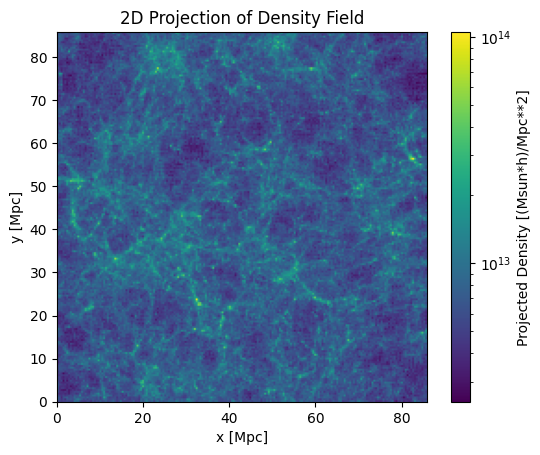

In [ ]:
# example usage from my snapshot files
plot_density(ss3, 200, m, halo_file=ss3_halos, plot_halos=False, label_halos=True)

Returning DM    Positions


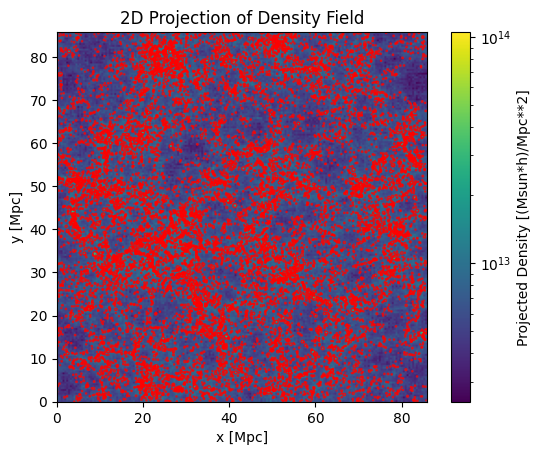

In [137]:
plot_density(ss3, 200, m, halo_file=ss3_halos, plot_halos=True)

In [253]:
def halo2df(halos, add_particles=False, halodic=None):
    '''
    "halos" arg should be of form: halos = readrockstargalaxies(halofile,'halos')
    convert the structured np arrays that all halos come in from pygadreader
    into a pandas DataFrame. Returns df, 
    If add_particles is True, then give it a halo dictionary of the form
    halodic = group_halos(readrockstargalaxies(halofile, 'particles'))
    and it will use the particle ids belonging
    to each halo to add another column to the dataframe containing
    arrays of corresponding particle ids for each halo.
    '''
    
    data_dict = {}
    for name in halos.dtype.names:
        field_data = halos[name]
        
        # if multidim field, store as list of arrays
        if field_data.ndim > 1 or (len(field_data.shape) > 1 and field_data.shape[1] > 1):
            data_dict[name] = [field_data[i] for i in range(len(field_data))]
        else:
            data_dict[name] = field_data

    df = pd.DataFrame(data_dict)

    if (add_particles is True) and (halodic is not None):
        df['pids'] = df['id'].map(halodic)
        
    return df


In [261]:
# data frames for all halos:
halodf2 = halo2df(halos2, add_particles=True, halodic=halodic2)
halodf3 = halo2df(halos3, add_particles=True, halodic=halodic3)
halodf4 = halo2df(halos4, add_particles=True, halodic=halodic4)

In [ ]:
# COMPARING HALOS BY PARTICLE MEMBERSHIP & OTHER PROPERTIES

In [ ]:
def compare_sets(set1, set2, printstats=True):
    '''compare sets helper function, takes two sets, computes the following list of stats:
    will print the stats if printstats=True, wont print them if False'''
    intersec = set1 & set2
    union = set1 | set2
    
    unique1 = set1 - set2
    unique2 = set2 - set1

    pct12 = len(intersec) / len(set1) * 100 
    pct21 = len(intersec) / len(set2) * 100 
    pcttot = len(intersec) / len(union) * 100 

    if printstats:
        print(f"common particles ({len(intersec)}): {np.array(sorted(intersec),dtype=int)}")
        print(f"unique to halo1 ({len(unique1)}): {np.array(sorted(unique1),dtype=int)}")
        print(f"unique to halo2 ({len(unique2)}): {np.array(sorted(unique2),dtype=int)}\n")
        print(f"percent of halo1 pids in halo2: {pct12:.2f}%")
        print(f"percent of halo2 pids in halo1: {pct21:.2f}%")
        print(f"percent of common pids out of total pids {pcttot:.2f}%\n")

    return pct12, pct21, pcttot, intersec, unique1, unique2


def compare_2halos(dic1, dic2, hid1, hid2, compare_prop=None, printstats=True, 
                   df1=None, df2=None):
    '''
    I want to give it two halo dictionaries (halo-->pid from group_halos fn), then tell it
    the halo id of the first one and then the halo id of the second one. It will get halos' pid
    arrays via the given halo ids. 
    Then it will return the percent of halo1 particles also in halo2, and it will return the percent
    of halo2 particles that are also in halo1, then it will return the percent of the particles
    that are the same relative to the union of the two halos: intersection/union as percent.
    also, you can choose to pass it a LIST of halo props (compare_prop) to compare between
    both. Must be list even if only one prop. Since there are many halo properties it will only
    print out difference calculations for all props. Also it requires pandas dataframes for both sets of
    halos, it will access the specific halos in their respective dfs via the given hids.
    Returns a dictionary of the props to compare with each one matched to a list of tuples of:
    (prop1, prop2, pctdiff, pctchg) --> pctdiff is the |prop2-prop2| / avg, and pctchg is (prop1-prop2) / prop2.
    Also can make printstats False to suppress print output.
    '''
    # dics from group_halos() fn:
    halo1 = dic1[hid1]
    halo2 = dic2[hid2]
    
    set1 = set(halo1)
    set2 = set(halo2)

    pct12, pct21, pcttot, intersec, unique1, unique2 = compare_sets(set1, set2, printstats)

    if compare_prop is not None:
        if df1 is None or df2 is None:
            raise ValueError("must provide dataframes to compare properties")

        prop_dic = {}
        for prop in compare_prop:
            prop1 = df1[prop][hid1]
            prop2 = df2[prop][hid2]

            pctdiff = 100 * np.abs(prop2-prop1) / ((prop1+prop2)/2.0)
            pctchg = (prop1 - prop2) / prop2 * 100
            prop_dic[prop] = (prop1, prop2, pctdiff, pctchg)

            if printstats is True:
                print(f"{prop} of halo1: {prop1}")
                print(f"{prop} of halo2: {prop2}")
                print(f"percent difference (|halo2-halo1| / avg): {pctdiff}%")
                print(f"percent change ((halo1-halo2) / halo2): {pctchg}%\n")

        return pct12, pct21, pcttot, intersec, unique1, unique2, prop_dic

    return pct12, pct21, pcttot, intersec, unique1, unique2


def halo_matches(target_dic, thid, catalog_dic, n=3, detailed=True):
    '''
    Given two halo dictionaries, where the first one (target_dic) contains the halo for whom you want to find a match,
    and the second (catalog_dic) contains the halos to compare it up against, and the halo id of the target halo
    in the first halo dic (thid), then this function will find the top n (default 3) matches for the target halo
    from the given halo catalog to check. The matches are characterized by the Jaccard index value; so the
    top n highest Jaccard index value halos will be reported.
    If you dont want particle info as well, then set detailed to False.
    Returns: the top matches as a list of tuples of the form (hid, dict) where the hid is the halo id of the 
    matching halo and the dict contains the statistics/particle info of each as given by the compare_2halos
    function. It also returns a dictionary of ALL halo ids in catalog mapped to tuples: (pct_target_in_other,
    pct_other_in_target, jaccard) for easier/more concise checking/comparing without all the particle arrays.
    '''
    
    target_set = set(target_dic[thid])
    allresults = {}
    detailed_results = []

    items = list(catalog_dic.items())
    
    for hid, other_halo in items:
        
        set_other = set(other_halo)
        pct_t_in_o, pct_o_in_t, intersec, common, uniq_t, uniq_o = compare_sets(target_set, set_other, printstats=False)
        jaccard = intersec/100.
        allresults[hid] = (pct_t_in_o, pct_o_in_t, jaccard)

        if detailed:
            detailsdic = {
                "pct_target_in_other": pct_t_in_o,
                "pct_other_in_target": pct_o_in_t,
                "jaccard": jaccard,
                "common_particles": np.array(sorted(common), dtype=int),
                "unique_to_target": np.array(sorted(uniq_t), dtype=int),
                "unique_to_other": np.array(sorted(uniq_o), dtype=int),
            }
        else:
            detailsdic = {"pct_target_in_other": pct_t_in_o,
                          "pct_other_in_target": pct_o_in_t,
                          "jaccard": jaccard}

        detailed_results.append((hid, detailsdic))

    sort_halos = sorted(detailed_results, key=lambda item: item[1]["jaccard"], reverse=True)
    top_matches = sort_halos[:n]
    return top_matches, allresults


In [32]:
def build_descendant_map(halo_dicts):
    """
    For each halo in each snapshot, find its main descendant in the next snapshot.
    
    Args:
        halo_dicts (list of dict): halo_id -> set(particle_ids) for each snapshot.
        
    Returns:
        dict mapping (snap, halo_id) -> (snap+1, descendant_id, retention_fraction)
    """
    descendants = {}
    
    for snap in range(len(halo_dicts) - 1):
        halos_now = halo_dicts[snap]
        halos_next = halo_dicts[snap+1]
        
        for hid_now, particles_now in halos_now.items():
            overlaps = []
            particles_now = set(particles_now)
            for hid_next, particles_next in halos_next.items():
                particles_next = set(particles_next)
                shared = len(particles_now & particles_next)
                if shared > 0:
                    frac = shared / len(particles_now)
                    overlaps.append((hid_next, frac))
            
            if overlaps:
                # Pick best match (max retention fraction)
                overlaps.sort(key=lambda x: x[1], reverse=True)
                best_hid, frac = overlaps[0]
                descendants[(snap, hid_now)] = (snap+1, best_hid, frac)
            else:
                # No descendant
                descendants[(snap, hid_now)] = (snap+1, None, 0.0)
    
    return descendants


def build_all_histories(halo_dicts, descendants):
    """
    Trace growth history for every halo in the first snapshot set where it appears.
    
    Args:
        halo_dicts: list of {halo_id -> set(particle_ids)}
        descendants: dict from build_descendant_map()
        
    Returns:
        dict: (snap, halo_id) -> list of (snap, halo_id, mass, retention_fraction)
    """
    histories = {}
    
    for snap in range(len(halo_dicts)):
        for hid, particles in halo_dicts[snap].items():
            key = (snap, hid)
            if key in histories:  # already tracked
                continue
            
            # start new history
            mass = len(particles)
            history = [(snap, hid, mass, 1.0)]
            current = key
            
            while current in descendants:
                next_snap, next_hid, frac = descendants[current]
                if next_hid is None:
                    history.append((next_snap, None, 0, 0.0))
                    break
                next_mass = len(halo_dicts[next_snap][next_hid])
                history.append((next_snap, next_hid, next_mass, frac))
                current = (next_snap, next_hid)
            
            histories[(snap, hid)] = history
    
    return histories

def plot_all_histories(histories, n=5):
    """Plot mass growth for n halos (random sample)."""
    keys = list(histories.keys())[:n]
    for key in keys:
        snaps = [h[0] for h in histories[key]]
        masses = [h[2] for h in histories[key]]
        plt.plot(snaps, masses, marker='o', label=f"Halo {key}")
        
    plt.xlabel("a")
    plt.ylabel("Number of Particles")
    plt.title(f"Number of Particles vs Time for {n} Halos")
    #plt.legend()
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

In [20]:
descendants = build_descendant_map(halo_dicts)

histories = build_all_histories(halo_dicts, descendants)


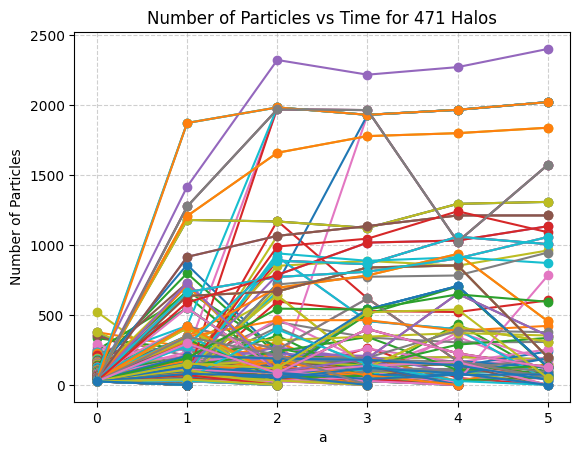

In [33]:
plot_all_histories(histories, n=471)

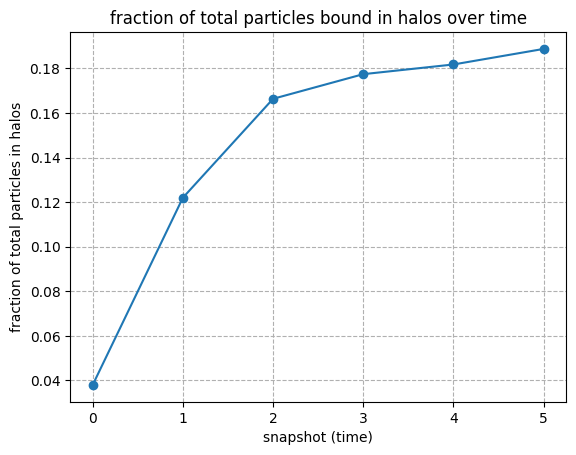

In [40]:
# total prtcles
N_total = 96.**3
fractions = []
for snap, halos in enumerate(halo_dicts):
    
    particles_in_halos = set()  #empty set
    for particle_set in halos.values(): 
        particles_in_halos = particles_in_halos.union(particle_set)
        
    frac = len(particles_in_halos)/N_total
    fractions.append(frac)
    
plt.plot(range(len(fractions)), fractions, marker="o")
plt.xlabel("snapshot (time)")
plt.ylabel("fraction of total particles in halos")
plt.title("fraction of total particles bound in halos over time")
plt.grid(True, linestyle="--")
plt.show()

In [35]:
example_key = (0, 0)  
for snap, hid, mass, frac in histories[example_key]:
    print(f"Snap {snap}, halo={hid}, # particles ={mass}, retention={frac:.2f}")
example_key = (0, 100)  
for snap, hid, mass, frac in histories[example_key]:
    print(f"Snap {snap}, halo={hid}, # particles ={mass}, retention={frac:.2f}")
example_key = (0, 200)  
for snap, hid, mass, frac in histories[example_key]:
    print(f"Snap {snap}, halo={hid}, # particles ={mass}, retention={frac:.2f}")
example_key = (0, 300)  
for snap, hid, mass, frac in histories[example_key]:
    print(f"Snap {snap}, halo={hid}, # particles ={mass}, retention={frac:.2f}")

Snap 0, halo=0, # particles =25, retention=1.00
Snap 1, halo=None, # particles =0, retention=0.00
Snap 0, halo=100, # particles =124, retention=1.00
Snap 1, halo=109, # particles =70, retention=0.22
Snap 2, halo=247, # particles =248, retention=0.60
Snap 3, halo=None, # particles =0, retention=0.00
Snap 0, halo=200, # particles =69, retention=1.00
Snap 1, halo=869, # particles =34, retention=0.13
Snap 2, halo=77, # particles =725, retention=0.03
Snap 3, halo=15, # particles =1930, retention=0.13
Snap 4, halo=17, # particles =1966, retention=0.59
Snap 5, halo=13, # particles =2021, retention=0.36
Snap 0, halo=300, # particles =44, retention=1.00
Snap 1, halo=None, # particles =0, retention=0.00


In [268]:
# testing:
#compare_2halos(dic1, dic2, hid1, hid2, compare_prop=None, printstats=True, df1=None, df2=None):
pct1, pct2, pct3, com, un1, un2 = compare_2halos(halodic2, halodic2, hid1=2, hid2=2)


common particles (28): [2697913 2697914 2697921 2697922 2697924 2697925 2697926 2697927 2697928
 2697929 2697930 2697931 2697932 2697933 2697934 2699515 2699516 2699525
 2699526 2699527 2699528 2699529 2699530 2699531 2699532 2699533 2699534
 2699535]
unique to halo1 (0): []
unique to halo2 (0): []

percent of halo1 pids in halo2: 100.00%
percent of halo2 pids in halo1: 100.00%
percent of common pids out of total pids 100.00%



In [269]:
pct1, pct2, pct3, com, un1, un2 = compare_2halos(halodic2, halodic3, hid1=2, hid2=0)


common particles (0): []
unique to halo1 (28): [2697913 2697914 2697921 2697922 2697924 2697925 2697926 2697927 2697928
 2697929 2697930 2697931 2697932 2697933 2697934 2699515 2699516 2699525
 2699526 2699527 2699528 2699529 2699530 2699531 2699532 2699533 2699534
 2699535]
unique to halo2 (108): [6903031 6903057 6903063 6903065 6903066 6903070 6903071 6903077 6903078
 6903079 6903081 6903083 6903086 6903088 6903090 6903091 6903093 6903094
 6903095 6903096 6903097 6903098 6903099 6903100 6903101 6903102 6903103
 6903104 6903105 6903106 6903107 6903108 6903109 6903110 6903112 6903117
 6903118 6903119 6903120 6903121 6903122 6903123 6903124 6903125 6903126
 6903127 6903128 6903129 6903130 6903131 6903132 6903133 6903134 6903135
 6903136 6903137 6903138 6903139 6903140 6903141 6903142 6903143 6903144
 6903146 6903147 6903149 6903150 6903151 6954442 6954523 6954548 6954549
 6954583 6954595 6954600 6954601 6954602 6954603 6954604 6954606 6954609
 6954610 6954611 6954612 6954613 6954615 695

In [270]:
pct1, pct2, pct3, com, un1, un2 = compare_2halos(halodic2, halodic3, hid1=0, hid2=7719)

common particles (22): [4448721 4448723 4448724 4448732 4448733 4448734 4448735 4448736 4448737
 4448738 4448740 4448741 4448742 4448743 4448744 4448745 4448746 4448749
 4448750 4448751 4448752 4448753]
unique to halo1 (9): [4448698 4448718 4448719 4448720 4448739 4448748 4450461 4450466 4450474]
unique to halo2 (25): [4448676 4448681 4448712 4448713 4448714 4448716 4448717 4448722 4448726
 4448727 4448729 4448730 4448754 4448756 4448759 4448760 4448761 4448762
 4448764 4448765 4448766 4448768 4448769 4448770 4448771]

percent of halo1 pids in halo2: 70.97%
percent of halo2 pids in halo1: 46.81%
percent of common pids out of total pids 39.29%



In [278]:
pct1, pct2, pct3, com, un1, un2, prop_dic = compare_2halos(halodic2, halodic2,
                                                           hid1=2, hid2=0, compare_prop = ['r', 'm'], df1 = halodf2, df2 = halodf2)

common particles (0): []
unique to halo1 (28): [2697913 2697914 2697921 2697922 2697924 2697925 2697926 2697927 2697928
 2697929 2697930 2697931 2697932 2697933 2697934 2699515 2699516 2699525
 2699526 2699527 2699528 2699529 2699530 2699531 2699532 2699533 2699534
 2699535]
unique to halo2 (31): [4448698 4448718 4448719 4448720 4448721 4448723 4448724 4448732 4448733
 4448734 4448735 4448736 4448737 4448738 4448739 4448740 4448741 4448742
 4448743 4448744 4448745 4448746 4448748 4448749 4448750 4448751 4448752
 4448753 4450461 4450466 4450474]

percent of halo1 pids in halo2: 0.00%
percent of halo2 pids in halo1: 0.00%
percent of common pids out of total pids 0.00%

r of halo1: 131.47921752929688
r of halo2: 89.53433990478516
percent difference (|halo2-halo1| / avg): 37.95683670043945%
percent change ((halo1-halo2) / halo2): 46.84781265258789%

m of halo1: 149904670720.0
m of halo2: 47338319872.0
percent difference (|halo2-halo1| / avg): 103.99999237060547%
percent change ((halo1-halo

In [279]:
pct1, pct2, pct3, com, un1, un2, prop_dic = compare_2halos(halodic2, halodic2,
                                                           hid1=0, hid2=0, compare_prop = ['r', 'm'], df1 = halodf2, df2 = halodf2)

common particles (31): [4448698 4448718 4448719 4448720 4448721 4448723 4448724 4448732 4448733
 4448734 4448735 4448736 4448737 4448738 4448739 4448740 4448741 4448742
 4448743 4448744 4448745 4448746 4448748 4448749 4448750 4448751 4448752
 4448753 4450461 4450466 4450474]
unique to halo1 (0): []
unique to halo2 (0): []

percent of halo1 pids in halo2: 100.00%
percent of halo2 pids in halo1: 100.00%
percent of common pids out of total pids 100.00%

r of halo1: 89.53433990478516
r of halo2: 89.53433990478516
percent difference (|halo2-halo1| / avg): 0.0%
percent change ((halo1-halo2) / halo2): 0.0%

m of halo1: 47338319872.0
m of halo2: 47338319872.0
percent difference (|halo2-halo1| / avg): 0.0%
percent change ((halo1-halo2) / halo2): 0.0%



In [281]:
pct1, pct2, pct3, com, un1, un2, prop_dic = compare_2halos(halodic2, halodic2,
                                                           hid1=2, hid2=0, compare_prop = ['r'], df1 = halodf2, df2 = halodf2)

common particles (0): []
unique to halo1 (28): [2697913 2697914 2697921 2697922 2697924 2697925 2697926 2697927 2697928
 2697929 2697930 2697931 2697932 2697933 2697934 2699515 2699516 2699525
 2699526 2699527 2699528 2699529 2699530 2699531 2699532 2699533 2699534
 2699535]
unique to halo2 (31): [4448698 4448718 4448719 4448720 4448721 4448723 4448724 4448732 4448733
 4448734 4448735 4448736 4448737 4448738 4448739 4448740 4448741 4448742
 4448743 4448744 4448745 4448746 4448748 4448749 4448750 4448751 4448752
 4448753 4450461 4450466 4450474]

percent of halo1 pids in halo2: 0.00%
percent of halo2 pids in halo1: 0.00%
percent of common pids out of total pids 0.00%

r of halo1: 131.47921752929688
r of halo2: 89.53433990478516
percent difference (|halo2-halo1| / avg): 37.95683670043945%
percent change ((halo1-halo2) / halo2): 46.84781265258789%



In [283]:
pct1, pct2, pct3, com, un1, un2, prop_dic = compare_2halos(halodic2, halodic3,
                                                           hid1=0, hid2=7719, compare_prop = ['pos'], df1 = halodf2, df2 = halodf3)

common particles (22): [4448721 4448723 4448724 4448732 4448733 4448734 4448735 4448736 4448737
 4448738 4448740 4448741 4448742 4448743 4448744 4448745 4448746 4448749
 4448750 4448751 4448752 4448753]
unique to halo1 (9): [4448698 4448718 4448719 4448720 4448739 4448748 4450461 4450466 4450474]
unique to halo2 (25): [4448676 4448681 4448712 4448713 4448714 4448716 4448717 4448722 4448726
 4448727 4448729 4448730 4448754 4448756 4448759 4448760 4448761 4448762
 4448764 4448765 4448766 4448768 4448769 4448770 4448771]

percent of halo1 pids in halo2: 70.97%
percent of halo2 pids in halo1: 46.81%
percent of common pids out of total pids 39.29%

pos of halo1: [  63.859665   22.513689    2.878455 -109.89088   -34.076492   38.165047]
pos of halo2: [61.503357 33.24015  58.390247 25.660334 57.834538 20.994555]
percent difference (|halo2-halo1| / avg): [   3.7591755   38.47793    181.20766   -321.8576     773.72546
   58.048035 ]%
percent change ((halo1-halo2) / halo2): [   3.831186  -32.2695

In [284]:
pct1, pct2, pct3, com, un1, un2, prop_dic = compare_2halos(halodic2, halodic2,
                                                           hid1=0, hid2=0, compare_prop = ['pos'], df1 = halodf2, df2 = halodf2)

common particles (31): [4448698 4448718 4448719 4448720 4448721 4448723 4448724 4448732 4448733
 4448734 4448735 4448736 4448737 4448738 4448739 4448740 4448741 4448742
 4448743 4448744 4448745 4448746 4448748 4448749 4448750 4448751 4448752
 4448753 4450461 4450466 4450474]
unique to halo1 (0): []
unique to halo2 (0): []

percent of halo1 pids in halo2: 100.00%
percent of halo2 pids in halo1: 100.00%
percent of common pids out of total pids 100.00%

pos of halo1: [  63.859665   22.513689    2.878455 -109.89088   -34.076492   38.165047]
pos of halo2: [  63.859665   22.513689    2.878455 -109.89088   -34.076492   38.165047]
percent difference (|halo2-halo1| / avg): [ 0.  0.  0. -0. -0.  0.]%
percent change ((halo1-halo2) / halo2): [ 0.  0.  0. -0. -0.  0.]%



In [285]:
target_dic = halodic3
catalog_dic = halodic4

In [286]:
top_matches, allresults = halo_matches(target_dic, 0, catalog_dic, n=3, detailed=False)

In [287]:
print(top_matches)

[(np.int64(5187), {'pct_target_in_other': 38.88888888888889, 'pct_other_in_target': 16.867469879518072, 'jaccard': 0.13333333333333333}), (np.int64(13179), {'pct_target_in_other': 6.481481481481481, 'pct_other_in_target': 17.94871794871795, 'jaccard': 0.05}), (np.int64(5188), {'pct_target_in_other': 3.7037037037037033, 'pct_other_in_target': 9.523809523809524, 'jaccard': 0.0273972602739726})]


In [288]:
print(allresults)

{np.int64(0): (0.0, 0.0, 0.0), np.int64(1): (0.0, 0.0, 0.0), np.int64(2): (0.0, 0.0, 0.0), np.int64(3): (0.0, 0.0, 0.0), np.int64(4): (0.0, 0.0, 0.0), np.int64(5): (0.0, 0.0, 0.0), np.int64(6): (0.0, 0.0, 0.0), np.int64(7): (0.0, 0.0, 0.0), np.int64(8): (0.0, 0.0, 0.0), np.int64(9): (0.0, 0.0, 0.0), np.int64(10): (0.0, 0.0, 0.0), np.int64(11): (0.0, 0.0, 0.0), np.int64(12): (0.0, 0.0, 0.0), np.int64(13): (0.0, 0.0, 0.0), np.int64(14): (0.0, 0.0, 0.0), np.int64(15): (0.0, 0.0, 0.0), np.int64(16): (0.0, 0.0, 0.0), np.int64(17): (0.0, 0.0, 0.0), np.int64(18): (0.0, 0.0, 0.0), np.int64(19): (0.0, 0.0, 0.0), np.int64(20): (0.0, 0.0, 0.0), np.int64(21): (0.0, 0.0, 0.0), np.int64(22): (0.0, 0.0, 0.0), np.int64(23): (0.0, 0.0, 0.0), np.int64(24): (0.0, 0.0, 0.0), np.int64(25): (0.0, 0.0, 0.0), np.int64(26): (0.0, 0.0, 0.0), np.int64(27): (0.0, 0.0, 0.0), np.int64(28): (0.0, 0.0, 0.0), np.int64(29): (0.0, 0.0, 0.0), np.int64(30): (0.0, 0.0, 0.0), np.int64(31): (0.0, 0.0, 0.0), np.int64(32): (0.

In [289]:
top_matches, allresults = halo_matches(halodic2, 0, halodic3, n=3, detailed=False)

In [290]:
top_matches

[(np.int64(7719),
  {'pct_target_in_other': 70.96774193548387,
   'pct_other_in_target': 46.808510638297875,
   'jaccard': 0.39285714285714285}),
 (np.int64(0),
  {'pct_target_in_other': 0.0, 'pct_other_in_target': 0.0, 'jaccard': 0.0}),
 (np.int64(1),
  {'pct_target_in_other': 0.0, 'pct_other_in_target': 0.0, 'jaccard': 0.0})]

In [ ]:
# TRACKING HOW HALOS EVOLVE OVER TIME

In [291]:
def plot_haloprop(halo_series, prop, times=None, hid=None):
    '''Plots halo properties as a function of scale factor a
    Args:
    halo_series is a list of pd.Series where each Series corresponds to
    the halo at a certain point of time
    prop: property value to plot (column name of Series)
    times: list of snapshot a values for x axis (if none given then it
    just goes up by 1)
    hid'''
    halodf = pd.DataFrame(halo_series)
    if times is None:
        times = list(range(len(halo_series)))
    plt.figure()
    plt.plot(times, halodf[prop], marker='o',linestyle='--')
    plt.xlabel('scale factor a')
    plt.ylabel(f"{prop} [units]")
    plt.grid(True)
    title = f'{prop} vs scale factor a'
    if hid is not None:
        title = f'{prop} vs scale factor a for hid: {hid}'
    plt.title(title)
    plt.show()

In [292]:
halo_t0 = halodf2.iloc[0]
halo_t1 = halodf3.iloc[0]
halo_t2 = halodf4.iloc[0]

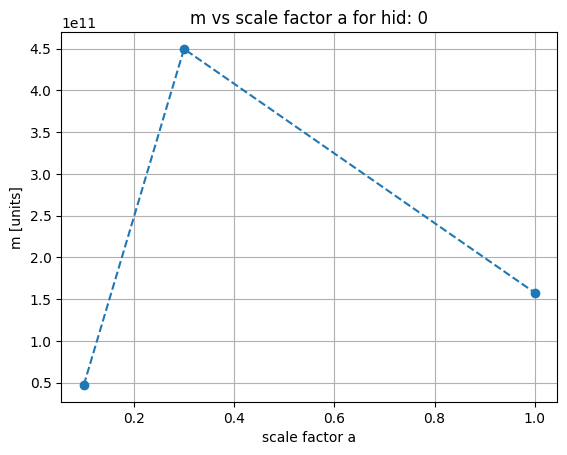

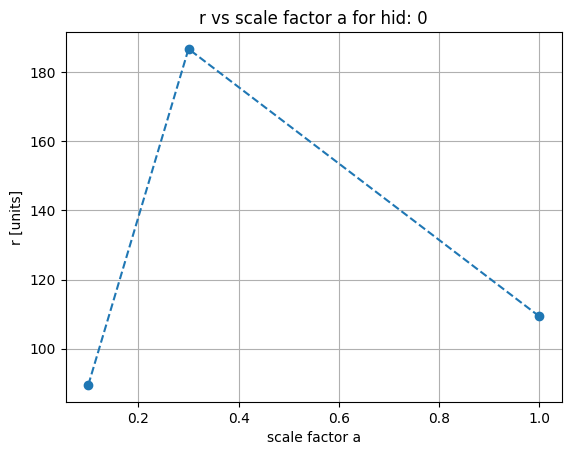

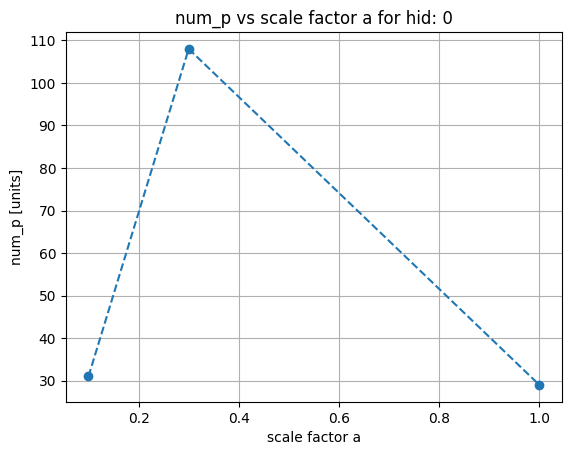

In [293]:
# Testing
# mass over time
plot_haloprop([halo_t0, halo_t1, halo_t2], prop='m', times=[0.1, 0.3, 1], hid=0)
# virial radius over time
plot_haloprop([halo_t0, halo_t1, halo_t2], prop='r', times=[0.1, 0.3, 1], hid=0)
# num_p over time
plot_haloprop([halo_t0, halo_t1, halo_t2], prop='num_p', times=[0.1, 0.3, 1], hid=0)

In [300]:
def track_halo(particle_ids, halo_dicts):
    '''Track halo over snapshots BY PARTICLES
    via top descendant for each iteration which is charatcerized by which one has most of the og
    particles
    particle_ids: array of pids of the halo at beginning ss. halo_dicts is a
    LIST of dicts over ss's where each one is of form halo_id -> list of particle IDs for that ss.
    returns a dictionary of the form
    'descendants': list of dicts PER SS with top descendant and fraction of particle kept for that
    top descendant
    'particle_table': df of particle -> halo host per ss
    '''
    particle_ids = list(particle_ids)
    n_snaps = len(halo_dicts)
    particle_table = pd.DataFrame(index=particle_ids, columns=[f'snap_{i}' for i in range(n_snaps)])
    particle_table['snap_0'] = None
    pid_to_halo_0 = {pid: hid for hid, pids in halo_dicts[0].items() for pid in pids if pid in particle_ids}
    for pid, hid in pid_to_halo_0.items():
        particle_table.at[pid, 'snap_0'] = hid
    descendants = []
    current_particles = set(particle_ids)
    for snap_idx, halo_dict in enumerate(halo_dicts[1:], start=1):
        # particle_id -> halo_id for current particles
        pid_to_halo = {pid: hid for hid, pids in halo_dict.items() for pid in pids if pid in current_particles}
        # update table
        for pid in particle_ids:
            particle_table.at[pid, f'snap_{snap_idx}'] = pid_to_halo.get(pid, None)
        if not pid_to_halo:
            descendants.append({
                'main_descendant': None,
                'retention_fraction': 0.0,
                'particle_distribution': Counter()
            })
            current_particles = set()
            continue
        halo_counts = Counter(pid_to_halo.values())
        main_descendant, count = halo_counts.most_common(1)[0]
        retention_fraction = count / len(current_particles)
        descendants.append({
            'main_descendant': main_descendant,
            'retention_fraction': retention_fraction,
            'particle_distribution': halo_counts})
        current_particles = set(pid for pid, hid in pid_to_halo.items() if hid == main_descendant)
    return {'descendants': descendants, 'particle_table': particle_table}


In [296]:
halo_dicts = [halodic2, halodic3, halodic4]

In [301]:
halo_id_to_track = 0
halo0_particles = halodic2[halo_id_to_track]
results = track_halo(halo0_particles, halo_dicts)
for i, d in enumerate(results['descendants'], start=1):
    print(f"Snapshot {i}: main descendant = {d['main_descendant']}, "
          f"retention = {d['retention_fraction']:.2f}")
    print(f"Particle distribution: {d['particle_distribution']}")
# per-particle tracking table
dfparticles = results['particle_table']
print(dfparticles)


Snapshot 1: main descendant = 7719, retention = 0.71
Particle distribution: Counter({np.int64(7719): 22})
Snapshot 2: main descendant = None, retention = 0.00
Particle distribution: Counter()
        snap_0 snap_1 snap_2
4448746      0   7719   None
4448733      0   7719   None
4448720      0   None   None
4448751      0   7719   None
4448745      0   7719   None
4448737      0   7719   None
4448744      0   7719   None
4448735      0   7719   None
4448732      0   7719   None
4448734      0   7719   None
4448741      0   7719   None
4448736      0   7719   None
4448740      0   7719   None
4448743      0   7719   None
4448719      0   None   None
4448752      0   7719   None
4448742      0   7719   None
4448723      0   7719   None
4448753      0   7719   None
4448750      0   7719   None
4448724      0   7719   None
4448748      0   None   None
4448718      0   None   None
4448749      0   7719   None
4448721      0   7719   None
4448738      0   7719   None
4450474      0   None   N

In [310]:
len(halodic2[0])

31

In [311]:
len(halodic2[1])

30

In [313]:
len(halodic3[7719])

47

In [298]:
# shows the list of dictionaries containing the halos main descendant and fraction retained for each ss,
# plus the particle table with just trakcs the halo that each particle belongs to across ss's
results 

{'descendants': [{'main_descendant': np.int64(7719),
   'retention_fraction': 0.7096774193548387,
   'particle_distribution': Counter({np.int64(7719): 22})},
  {'main_descendant': None,
   'retention_fraction': 0.0,
   'particle_distribution': Counter()}],
 'particle_table':         snap_0 snap_1 snap_2
 4448746      0   7719   None
 4448733      0   7719   None
 4448720      0   None   None
 4448751      0   7719   None
 4448745      0   7719   None
 4448737      0   7719   None
 4448744      0   7719   None
 4448735      0   7719   None
 4448732      0   7719   None
 4448734      0   7719   None
 4448741      0   7719   None
 4448736      0   7719   None
 4448740      0   7719   None
 4448743      0   7719   None
 4448719      0   None   None
 4448752      0   7719   None
 4448742      0   7719   None
 4448723      0   7719   None
 4448753      0   7719   None
 4448750      0   7719   None
 4448724      0   7719   None
 4448748      0   None   None
 4448718      0   None   None
 4448

In [299]:
results['particle_table']

,snap_0,snap_1,snap_2
4448746,0,7719,None
4448733,0,7719,None
4448720,0,None,None
4448751,0,7719,None
4448745,0,7719,None
4448737,0,7719,None
4448744,0,7719,None
4448735,0,7719,None
4448732,0,7719,None
4448734,0,7719,None


In [302]:
def plot_halo_evolution(results, snapshot_labels):
    '''
    plotter function using the results from previous track_halo fn, will just plot
    the fraction of particles retained over time
    results: needs to be from track_halo()
    snapshot_labels: manually enter scale factor a until I figure out how to
    access it via file and then I can add to DFs
    Plot halo evolution and particle retention over snapshots.
    '''
    descendants = results['descendants']
    n_snaps = len(descendants) + 1  # include snapshot 0
    retention = [1.0]  # snapshot 0: full halo
    retention += [d['retention_fraction'] for d in descendants]
    fig, ax1 = plt.subplots(figsize=(10,5))
    ax1.plot(snapshot_labels, retention, marker='o', color='blue', label='retention fraction')
    ax1.set_ylabel("particle retention fraction")
    ax1.set_ylim(0, 1.05)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.set_xlabel("scale factor a")
    ax1.set_title("tracking halo")
    main_halos = [None] + [d['main_descendant'] for d in descendants]
    ax2 = ax1.twinx()
    ax2.plot(snapshot_labels, main_halos, marker='o', linestyle='--', color='red', label='main halo ID')
    ax2.set_ylabel("main halo ID")
    ax2.tick_params(axis='y', labelcolor='red')
    ax1.grid(True, linestyle='--', alpha=0.5)
    plt.show()


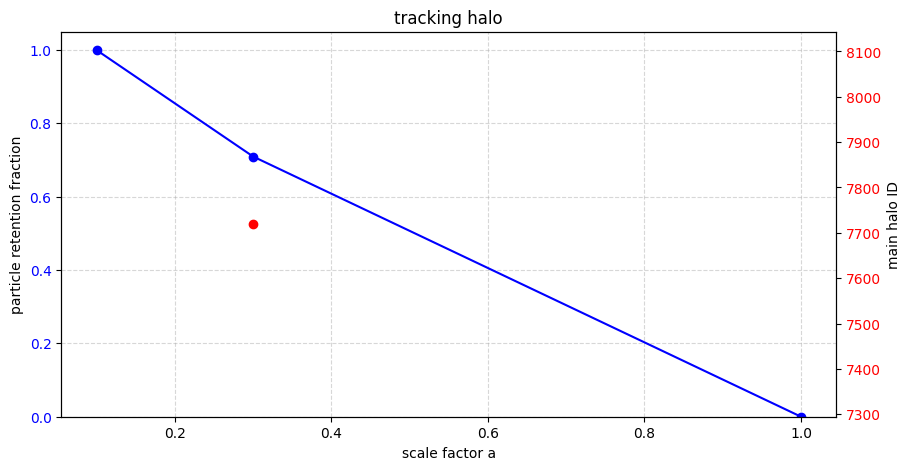

In [303]:
plot_halo_evolution(results, [0.1, 0.3, 1])

In [304]:
def plot_particle_distribution(results, snapshot_labels, top_n=5):
    '''
    another plotter function for track_halo
    will just plot the particle distribution across halos (bar graph)
    for each snapshot. top_n: only shows top n halos as distinct entities, if more than call them "other"
    '''
    descendants = results['descendants']
    n_snaps = len(descendants) + 1  # include snapshot 0
    particle_ids = results['particle_table'].index.tolist()
    n_particles = len(particle_ids)
    distributions = []
    pid0_to_halo = results['particle_table']['snap_0'].to_dict()
    counts0 = Counter(pid0_to_halo.values())
    distributions.append(counts0)
    for d in descendants:
        distributions.append(d['particle_distribution'])
    # Optional snapshot labels
    if snapshot_labels is None:
        snapshot_labels = [f"S{i}" for i in range(n_snaps)]
    all_halos = Counter()
    for dist in distributions:
        all_halos.update(dist)
    top_halos = [hid for hid, _ in all_halos.most_common(top_n)]
    bar_data = []
    for dist in distributions:
        row = []
        other_count = 0
        for hid in top_halos:
            row.append(dist.get(hid, 0))
        # Count remaining halos as 'Other'
        other_count = sum(count for hid, count in dist.items() if hid not in top_halos)
        row.append(other_count)
        bar_data.append(row)
    bar_data = np.array(bar_data).T  # shape: n_halos x n_snapshots
    labels = [str(hid) for hid in top_halos] + ['other halos']
    colors = plt.cm.tab20.colors[:len(labels)]
    fig, ax = plt.subplots(figsize=(10,5))
    bottom = np.zeros(n_snaps)
    for i in range(len(labels)):
        ax.bar(snapshot_labels, bar_data[i]/n_particles, bottom=bottom, color=colors[i], label=labels[i])
        bottom += bar_data[i]/n_particles
    ax.set_ylabel("fraction of original particles")
    ax.set_xlabel("scale factor a")
    ax.set_title("particle Distribution over halos")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

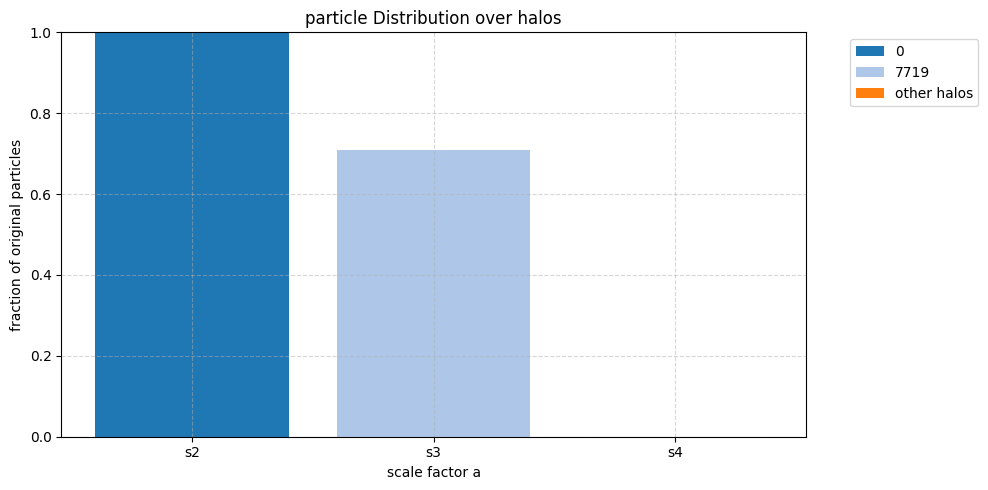

In [307]:
plot_particle_distribution(results, ['s2', 's3', 's4'], top_n=5)